# Creating PDF Reports with Pandas, Jinja and WeasyPrint
[http://pbpython.com/pdf-reports.html](http://pbpython.com/pdf-reports.html) 

First of all I've mocked some data on Mockaroo

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import io
import os

In [2]:
df = pd.read_csv("../data/sales_report.csv", sep=',', encoding='utf-8')
df.head()

,Account,Name,Company,Manager,Product,Quantity,Price
0,383834,Izaak Tattersall,"Bahringer, Balistreri and Dickens",Gloria Osbaldeston,Pork - Ham Hocks - Smoked,1,$453.55
1,656536,Enoch Nasey,Feeney-Aufderhar,Johnny Pearde,Wine - Chenin Blanc K.w.v.,2,$760.73
2,627574,Clifford Dursley,Moen Inc,Earle Geaney,Raisin - Golden,3,$320.12
3,707250,Peta Juliff,Pacocha and Sons,Paloma Sheavills,Carbonated Water - Raspberry,4,$132.22
4,532894,Shaina Estick,Block LLC,Giovanni Schwier,Steampan Lid,5,$520.72


In [3]:
price_to_num = lambda x: float(x.replace("$",""))
df['Price'] = df['Price'].map(price_to_num)

In [4]:
df.head()

,Account,Name,Company,Manager,Product,Quantity,Price
0,383834,Izaak Tattersall,"Bahringer, Balistreri and Dickens",Gloria Osbaldeston,Pork - Ham Hocks - Smoked,1,453.55
1,656536,Enoch Nasey,Feeney-Aufderhar,Johnny Pearde,Wine - Chenin Blanc K.w.v.,2,760.73
2,627574,Clifford Dursley,Moen Inc,Earle Geaney,Raisin - Golden,3,320.12
3,707250,Peta Juliff,Pacocha and Sons,Paloma Sheavills,Carbonated Water - Raspberry,4,132.22
4,532894,Shaina Estick,Block LLC,Giovanni Schwier,Steampan Lid,5,520.72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
Account     1000 non-null int64
Name        1000 non-null object
Company     1000 non-null object
Manager     1000 non-null object
Product     1000 non-null object
Quantity    1000 non-null int64
Price       1000 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB


In [6]:
df.sort_values(by=['Company','Product'],inplace=True)

In [7]:
sales_pivot = df.pivot_table(index=['Company','Product'],
                             values=['Quantity','Price'],
                             aggfunc=[np.sum,np.mean],
                             fill_value=0)
sales_pivot.head()

sum           \
                                                             Price Quantity   
Company                 Product                                               
Abbott, Beer and Wisozk Ice Cream Bar - Oreo Cone           541.42      923   
Abbott, Metz and Emard  Sprouts - Pea                       779.21      213   
Abbott-Borer            Mints - Striped Red                 957.16      382   
Abernathy LLC           Prunes - Pitted                     990.19      595   
Abernathy and Sons      Wine - Touraine Azay - Le - Rideau  340.63      847   

                                                              mean           
                                                             Price Quantity  
Company                 Product                                              
Abbott, Beer and Wisozk Ice Cream Bar - Oreo Cone           541.42      923  
Abbott, Metz and Emard  Sprouts - Pea                       779.21      213  
Abbott-Borer            Mints - Striped Red                 957.16      382  
Abernathy LLC           Prunes - Pitted                     990.19      595  
Abernathy and Sons      Wine - Touraine Azay - Le - Rideau  340.63      847

In [8]:
df['Product'].value_counts().head()

Wine - Gato Negro Cabernet        4
Banana - Green                    3
Cake - Miini Cheesecake Cherry    3
Bandage - Fexible 1x3             3
Pork - Tenderloin, Frozen         3
Name: Product, dtype: int64

In [9]:
print(df[df['Product']=='Wine - Gato Negro Cabernet']['Quantity'].mean())
print(df[df['Product']=='Pork - Tenderloin, Frozen']['Price'].mean())
print(df[df['Product']=='Wine - Gato Negro Cabernet']['Quantity'].mean())
print(df[df['Product']=='Pork - Tenderloin, Frozen']['Price'].mean())

423.75
354.46666666666664
423.75
354.46666666666664


### Send to clipboard

Here is a very interesting tool when you are working with pandas.
You can simples use this function, send data to clipboard and paste on excel.
Documentation: [link](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_clipboard.html)

```python
df.to_clipboard()
```

### Notes

Requirements for your platform:
* Linux: xclip, or xsel (with gtk or PyQt4 modules)
* Windows: none
* OS X: none

In [10]:
df.to_clipboard()

PyperclipException: 
    Pyperclip could not find a copy/paste mechanism for your system.
    For more information, please visit https://pyperclip.readthedocs.org 

## Templating
Jinja is very powerfull and it's very common to use with python, it allows you to "code" inside a HTML template.

Jinja has some [builtin filters](http://jinja.pocoo.org/docs/dev/templates/#builtin-filters) that allows you to format data.

So to start let's take a look in a simple Jinja template:

```html
<!DOCTYPE html>
<html>
<head lang="en">
    <meta charset="UTF-8">
    <title>{{ title }}</title>
</head>
<body>
    <h2>Sales Report</h2>
     {{ sales_pivot }}
</body>
</html>
```

These variables inside **{{ }}** can be used to place your data in.

In [13]:
import jinja2
envi = jinja2.Environment(loader=jinja2.FileSystemLoader('../templates/'))
template = envi.get_template("report_template.html")

In [14]:
template_vars = {'title' : 'Sales',
                 'sales_pivot' : sales_pivot.to_html()}

In [15]:
html_out = template.render(template_vars)

## Generate PDF

On windows I got this error:
```msg
OSError: dlopen() failed to load a library: cairo / cairo-2
```

So I decided to switch to ubuntu to test asap.

Possible solution:
[Looks like you don't have cairo installed](https://github.com/Kozea/CairoSVG/issues/84)

In [16]:
from weasyprint import HTML

In [17]:
HTML(string=html_out).write_pdf('../reports/report.pdf')

You can use css style as well, just add stylesheets params

In [18]:
HTML(string=html_out).write_pdf('../reports/report_css.pdf', stylesheets=["../templates/assets/css/style.css"])

## Printing a chart

In [19]:
data_dict = [{'Descrição': 'Avaliaram', 'Valor': 10},
            {'Descrição': 'Não Avaliaram', 'Valor': 5}]

values = []

In [20]:
data = pd.DataFrame(data_dict)
data.head()

,Descrição,Valor
0,Avaliaram,10
1,Não Avaliaram,5


In [21]:
import matplotlib.pyplot as plt

In [22]:
def make_autopct(values):
    """ Get values in a format ##% (##) to a chart """
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.0f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

Params to print chart 

In [23]:
plot_params = {
    'y':'Valor',
    'kind':'pie',
    'figsize':(2.8, 2.8),
    'labels':data['Descrição'],
    'legend':False,
    'autopct':make_autopct(data['Valor'])
}

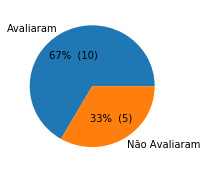

In [24]:
plot = data.plot(**plot_params)
_ = plot.set_ylabel("")

In [25]:
fig = plot.get_figure()

### Convert chart to html

Convert figure in a BytesIO and get a String in base64 to send to html.

[Converting matplotlib png to base64 for viewing in html template](https://stackoverflow.com/questions/31492525/converting-matplotlib-png-to-base64-for-viewing-in-html-template)

Chart uses the following template:

```html
<!DOCTYPE html>
<html>
<head lang="en">
    <meta charset="UTF-8">
    <title>{{ title }}</title>
</head>
<body>
    <h2>Pie Chart</h2>
     <img src="data:image/png;base64,{{ chart }}"\>
</body>
</html>
```

In [26]:
from io import BytesIO
figfile = BytesIO()
fig.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = figfile.getvalue()
import base64
figdata_png = base64.b64encode(figfile.getvalue()).decode('utf8')

In [27]:
template_vars = {'title' : 'Pie Chart',
                 'chart' : figdata_png}

In [28]:
template = envi.get_template("report_template_fig.html")

In [29]:
html_out = template.render(template_vars)

In [30]:
HTML(string=html_out).write_pdf('../reports/report_fig.pdf', stylesheets=["../templates/assets/css/style.css"])

## Printing a chart aside a column 

For this step I use a two column to show information on left

In [31]:
template_vars = {'chart' : figdata_png,
                 'chart_title' : 'Professores',
                 'professores_q_avaliaram' : 10,
                 'professores_q_nao_avaliaram' : 5,
                 'title' : 'Relatório'
                }

In [32]:
template = envi.get_template("report_template_columns.html")
html_out = template.render(template_vars)
HTML(string=html_out).write_pdf('../reports/report_columns.pdf')

## Printing summary

In [33]:
import datetime

In [34]:
template_vars = {'chart' : figdata_png,
                 'formadora' : 'Mary Jones',
                 'email_formadora' : 'mary@formacao.com.br',
                 'municipio' : 'Liberty City',
                 'start_date' : '01/04',
                 'end_date' : '01/04',
                 'current_week' : 4,
                 'last_week' : 5,
                 'disciplina' : 'História',
                 'professores_participantes' :  15,
                 'professores_q_avaliaram' : 10,
                 'avaliacoes_realizadas' : 12,
                 'professores_q_nao_avaliaram' : 5,
                 'prof_acessaram' : 11,
                 'prof_q_n_entraram' : 4,
                 'meta_planos' : 4,
                 'prof_ok' : 8,
                 'prof_n_ok' : 7,
                 'title' : 'Relatório',
                 'sales_pivot' : sales_pivot.to_html(),
                 'created_at' : '2018-04-14'
                }

In [43]:
template = envi.get_template("report_template_summary.html")
html_out = template.render(template_vars)
HTML(string=html_out).write_pdf('../reports/report_summary.pdf',stylesheets=["../templates/assets/css/style.css","../templates/assets/css/summary.css"])

https://www.smashingmagazine.com/2015/01/designing-for-print-with-css/